In [1]:
%pylab inline
import numpy as np
import pandas as pd
import os, sys
import random
import networkx as nx
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import SAD as sad

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

(mu, var) 0.017389971190909605 0.0006114559616211559


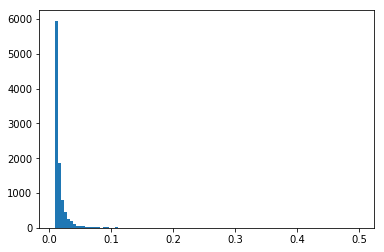

In [3]:
N = 10000
# produce activities 
from scipy.stats import norm,pareto
b = 2.1
dist = pareto(b).rvs(100000)
dist = np.random.choice(dist,N)
act = dict(zip(range(N),dist/(2.0*np.max(dist))))
plt.hist(act.values(),100)
mu, v  = np.mean(act.values()), np.mean(np.array(act.values())**2)
print '(mu, var)', mu, v

# Memoryless graph

In [ ]:
T = 3000
Tagg = 499;
k = 5
print 'instant average degree ~', mu * k*(k-1)/2
print 'final average degree ~', T * mu * k*(k-1)/2

instant average degree ~ 0.17389971190909603
final average degree ~ 521.6991357272882


In [ ]:
STG = {}
VTG = {}

sigmas = np.linspace(0,0.5,5);
for sigma in log_progress(sigmas):
    VTG[sigma],fh = sad.temporal_graph_creation(N,T,[k,k*sigma],act,mode='simplicial',returnhist=True);
    tot = []
    for t in fh:
        tot.extend(map(len,fh[t]))
    krenorm = int(round(sad.invert_k(np.mean(map(lambda x: x*(x-1)/2, tot)))))
    print sigma, krenorm
    STG[sigma] = sad.temporal_graph_creation(N,T,krenorm,act,mode='network')


VBox(children=(HTML(value=u''), IntProgress(value=0, max=5)))

0.0 5
0.125 5
0.25 5


In [ ]:
STGa = {}
VTGa = {}

for sigma in sigmas:
    VTGa[sigma] = sad.aggregate_graph(VTG,Tagg)
    STGa[sigma] = sad.aggregate_graph(STG,Tagg)

In [ ]:
pl = 4 
for sigma in sigmas:
    fig = plt.figure(figsize=(16,4))
    plt.subplot(1,pl,1)
    aa, bb = np.histogram(STGa[sigma].degree().values(), 30)
    plt.plot(bb[:-1],aa,'o-',label='STGa[sigma]')
    aa, bb = np.histogram(VTGa[sigma].degree().values(), 30)
    plt.plot(bb[:-1],aa,'o-',label='VTGa')
    plt.legend(loc=0)
#    plt.xscale('log')
    plt.yscale('log') 
    plt.title('Degree')

    plt.subplot(1,pl,2)
    aa, bb = np.histogram(nx.get_edge_attributes(STGa[sigma],'weight').values(), 30)
    plt.plot(bb[:-1],aa,'o-')
    aa, bb = np.histogram(nx.get_edge_attributes(VTGa[sigma],'weight').values(), 30)
    plt.plot(bb[:-1],aa,'o-')
#    plt.xscale('log')
    plt.yscale('log') 
    plt.title('Strength')

    plt.subplot(1,pl,3)
    aa, bb = np.histogram(nx.clustering(STGa[sigma]).values(), 30)
    plt.plot(bb[:-1],aa,'o-')
    aa, bb = np.histogram(nx.clustering(VTGa[sigma]).values(), 30)
    plt.plot(bb[:-1],aa,'o-')
    plt.xscale('log')
    plt.yscale('log') 
    plt.title('Clustering')
    plt.xlim(0,1)

    plt.subplot(1,pl,4)
    coreness, layerness = sad.onion_decomposition(STGa[sigma])
    aa, bb = np.histogram(layerness.values(), range(50), normed=True)
    plt.plot(bb[:-1],aa,'o-')
    coreness, layerness = sad.onion_decomposition(VTGa[sigma])
    aa, bb = np.histogram(layerness.values(), range(50), normed=True)
    plt.plot(bb[:-1],aa,'o-')
    plt.title('Layer number')

    plt.tight_layout()

In [ ]:
x = nx.clustering(VTGa[sigmas[-1]]).values()
y = nx.clustering(STGa[sigmas[-1]]).values()
z = act.values()[:N]
M = np.max([np.max(x), np.max(y)])

fig = plt.figure(figsize=(12,8))
plt.scatter(x,y,c=z,alpha=0.4)
plt.colorbar()
plt.plot(np.linspace(0,M,10),np.linspace(0,M,10),'--k')
plt.ylabel('Clustering STG',fontsize=30)
plt.xlabel('Clustering NTG', fontsize=30)


# Memory graph 

In [ ]:
import imp
imp.reload(sad)

In [ ]:
def invert_k(M):
    return (1.0 + np.sqrt(1 + 8*M))/2.0;

In [ ]:
STGa = {}
VTGa = {}
k = 6;
sigmas = np.linspace(0,1,5);
for sigma in sigmas:
    VTG,fh = sad.memory_temporal_graph_creation(N,T,[k,k*sigma],act,mode='simplicial',alpha=1,returnhist=True);
    VTGa[sigma] = sad.aggregate_graph(VTG,Tagg)
    tot = []
    for t in fh:
        tot.extend(map(len,fh[t]))
    krenorm = int(round(sad.invert_k(np.mean(map(lambda x: x*(x-1)/2, tot)))))
    print sigma, krenorm
    STG = sad.memory_temporal_graph_creation(N,T,krenorm,act,mode='simplicial',alpha=1)
    STGa[sigma] = sad.aggregate_graph(STG,Tagg)

In [ ]:
pl = 4 
for sigma in sigmas:
    fig = plt.figure(figsize=(16,4))
    plt.subplot(1,pl,1)
    aa, bb = np.histogram(STGa[sigma].degree().values(), 30)
    plt.plot(bb[:-1],aa,'o-',label='STGa[sigma]')
    aa, bb = np.histogram(VTGa[sigma].degree().values(), 30)
    plt.plot(bb[:-1],aa,'o-',label='VTGa')
    plt.legend(loc=0)
#    plt.xscale('log')
    plt.yscale('log') 
    plt.title('Degree')

    plt.subplot(1,pl,2)
    aa, bb = np.histogram(nx.get_edge_attributes(STGa[sigma],'weight').values(), 30)
    plt.plot(bb[:-1],aa,'o-')
    aa, bb = np.histogram(nx.get_edge_attributes(VTGa[sigma],'weight').values(), 30)
    plt.plot(bb[:-1],aa,'o-')
#    plt.xscale('log')
    plt.yscale('log') 
    plt.title('Strength')

    plt.subplot(1,pl,3)
    aa, bb = np.histogram(nx.clustering(STGa[sigma]).values(), 30)
    plt.plot(bb[:-1],aa,'o-')
    aa, bb = np.histogram(nx.clustering(VTGa[sigma]).values(), 30)
    plt.plot(bb[:-1],aa,'o-')
    plt.xscale('log')
    plt.yscale('log') 
    plt.title('Clustering')
    plt.xlim(0,1)

    plt.subplot(1,pl,4)
    coreness, layerness = sad.onion_decomposition(STGa[sigma])
    aa, bb = np.histogram(layerness.values(), range(50), normed=True)
    plt.plot(bb[:-1],aa,'o-')
    coreness, layerness = sad.onion_decomposition(VTGa[sigma])
    aa, bb = np.histogram(layerness.values(), range(50), normed=True)
    plt.plot(bb[:-1],aa,'o-')
    plt.title('Layer number')

    plt.tight_layout()

In [ ]:
STGa[sigmas[-1]].number_of_edges(), VTGa[sigmas[-1]].number_of_edges()

In [ ]:
x = nx.clustering(VTGa[sigmas[-1]]).values()
y = nx.clustering(STGa).values()
z = act.values()[:N]
M = np.max([np.max(x), np.max(y)])

fig = plt.figure(figsize=(12,8))
plt.scatter(x,y,c=z,alpha=0.4)
plt.colorbar()
plt.plot(np.linspace(0,M,10),np.linspace(0,M,10),'--k')
plt.ylabel('Clustering STG',fontsize=30)
plt.xlabel('Clustering NTG', fontsize=30)


In [ ]:
x, x0 = sad.onion_decomposition(VTGa[sigmas[-1]])
y, y0 = sad.onion_decomposition(STGa[sigmas[-1]])
z = act.values()[:N]
M = np.max([np.max(x.values()), np.max(y.values())])

fig = plt.figure(figsize=(12,8))
plt.scatter(x0.values(),y0.values(),c=x.values(),s=3*np.array(y.values()),alpha=0.4)
plt.colorbar()
plt.plot(np.linspace(0,M,10),np.linspace(0,M,10),'--k')
plt.ylabel('Layer STG',fontsize=30)
plt.xlabel('Layer NTG', fontsize=30)


- coreness network vs simplicial  (N>> now, act bassa, tempi lunghi, densita' bassa)
- coreness APS vs activity driven vs SAD 
- complex contagion cascade (https://arxiv.org/pdf/1207.1206.pdf)
- voter model (sims)
- omologia APS (???) 

